In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import missingno as msno
from functions import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split

import statsmodels.api as sm

# Read in the Data w/ explicit column names

In [3]:
column_names = ['age' , 'workclass' , 'fnlwgt' , 'education' , 'education_num' , 'marital_status' , 'occupation' , 'relationship' , 'race' , 'sex' , 'capital_gain' , 'capital_loss' , 'hours_per_week' , 'native_country', "target"]

In [4]:
adultDF = pd.read_csv('./data/adult.data', index_col=False, names=column_names)

# Clean the Data

### Strip the data of all white space

In [5]:
adultDF = strip_spaces(adultDF)

stripped leading/trailing spaces from all cells of string type


### replace all ? marks with NaN values

In [6]:
columns_with_placeholders = ['workclass', 'occupation', 'native_country']
adultDF = replace_column_w_nan(adultDF,columns_with_placeholders, "?")

Replaced ? values from these columns:['workclass', 'occupation', 'native_country']


### Replace other placeholders with Nan values

In [7]:
adultDF.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [8]:
for column in adultDF.columns:
    print(adultDF[column].value_counts().sort_index(ascending=False)[:5])
    print('\n')

90    43
88     3
87     1
86     1
85     3
Name: age, dtype: int64


Without-pay            14
State-gov            1298
Self-emp-not-inc     2541
Self-emp-inc         1116
Private             22696
Name: workclass, dtype: int64


1484705    1
1455435    1
1366120    1
1268339    1
1226583    1
Name: fnlwgt, dtype: int64


Some-college     7291
Prof-school       576
Preschool          51
Masters          1723
HS-grad         10501
Name: education, dtype: int64


16     413
15     576
14    1723
13    5355
12    1067
Name: education_num, dtype: int64


Widowed                    993
Separated                 1025
Never-married            10683
Married-spouse-absent      418
Married-civ-spouse       14976
Name: marital_status, dtype: int64


Transport-moving    1597
Tech-support         928
Sales               3650
Protective-serv      649
Prof-specialty      4140
Name: occupation, dtype: int64


Wife              1568
Unmarried         3446
Own-child         5068
Other-relative     98

From this report we can see that when it comes to columns like `capital_loss`, `hours_per_week`, and even `age`, although we see max values way past the 75th percentile, they aren't isolated instances. There are actually clusters of high values, which indicates that there might be a trend.

On the other hand, the `capital_gain` column shows 159 instances of an isolated value of 99,999. The next closest value is 41k, which indicates that the value 99,999 is likely a placeholder that needs to be addressed.

In [9]:
adultDF = replace_column_w_nan(adultDF,['capital_gain'], 99999)
columns_with_placeholders.append("capital_gain")

Replaced 99999 values from these columns:['capital_gain']


### Drop NaN rows

In [10]:
for column in columns_with_placeholders:
    missing_values = adultDF[column].isna().sum()
    total_rows = adultDF.shape[0]
    percentage = missing_values / total_rows
    percentage = round(percentage * 100, 2)
    print("The {} column is missing {}% of rows".format(column, percentage))

The workclass column is missing 5.64% of rows
The occupation column is missing 5.66% of rows
The native_country column is missing 1.79% of rows
The capital_gain column is missing 0.49% of rows


Because of the results above, we can remove rows without affecting our data

In [11]:
adultDF = drop_na_rows(adultDF, columns_with_placeholders)

Removed NA rows from these columns:['workclass', 'occupation', 'native_country', 'capital_gain'].


### Drop Duplicates

In [12]:
round(adultDF.duplicated().sum()/adultDF.shape[0]*100, 2)

0.08

because only .08% of our data is duplicated, we can remove these rows without much affect

In [13]:
adultDF = adultDF.drop_duplicates()
check_duplicates(adultDF)

You're all clear of duplicates


# Review First Round of DataCleaning

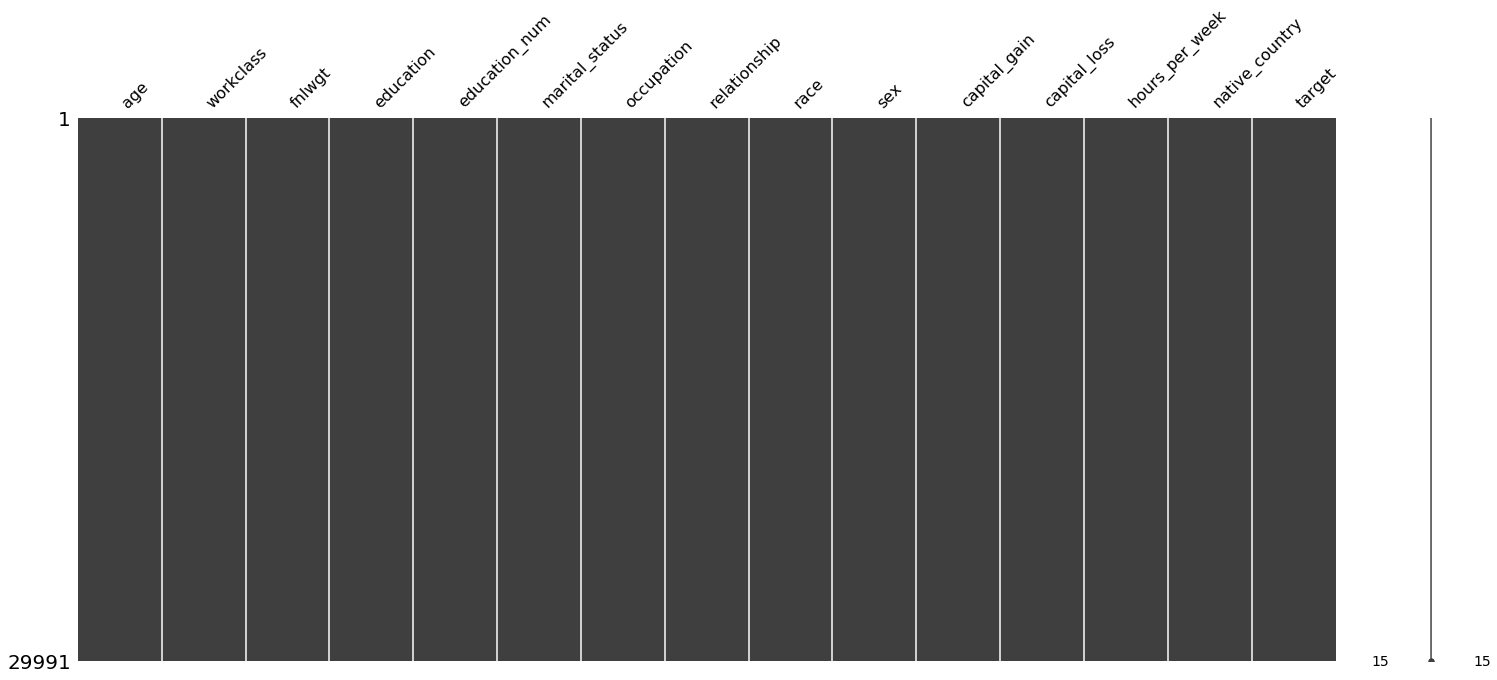

In [14]:
msno.matrix(adultDF)

At this point, we have stripped all white spaces, removed 24 duplicates, replaced '?' and '99,999' values with NaNs, and finally dropped all rows with missing values.

We don't see a need to drop any columns for cleaned data - we'll leave that for the model notebook to determine which columns are relevant or not. 

## Change target to binary column

In [15]:
adultDF.target.unique()

array(['<=50K', '>50K'], dtype=object)

In [16]:
adultDF.target = adultDF.target.map(lambda x: np.where(x == '>50K', 1, 0))

In [17]:
adultDF.target.unique()

array([0, 1])

#### We have an imbalanced class problem below

In [18]:
adultDF.target.value_counts(normalize=True)

0    0.75466
1    0.24534
Name: target, dtype: float64

# Train_Test_Split Data

### We are going to dummify our categorical columns in the dataframe

In [19]:
categorical_columns = ['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'marital_status', 'native_country']

In [20]:
dummy_df = pd.get_dummies(adultDF,columns=categorical_columns)

In [36]:
X = dummy_df.loc[:, dummy_df.columns != 'target']
y = dummy_df.target

In [37]:
y.value_counts()

0    22633
1     7358
Name: target, dtype: int64

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=40,stratify=y)

In [40]:
y_train.head()

15612    1
12340    0
31616    0
13753    0
6311     0
Name: target, dtype: int64

In [41]:
pickled_df= pd.to_pickle(dummy_df, './data/cleaned_df.pkl')

trained_pickle= pd.to_pickle(X_train.join(y_train), './data/trained_pickle.pkl')

tested_pickle= pd.to_pickle(X_test.join(y_test), './data/tested_pickle.pkl')